In [1]:
import logging
import numpy as np
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, accuracy_score, classification_report, confusion_matrix
from transformers import AutoImageProcessor, DefaultDataCollator
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
from transformers import pipeline
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
import evaluate
import itertools
import sys
sys.path.append('../src')
import datafeed as feed

# Load Data

In [4]:
ls = feed.get_image_list()
#feed.collect_statistics(ls)
ds = feed.get_dataset_with_transform(ls, feed.transform_vit)

# Split Data

In [5]:
ds_split = feed.split_dataset_train_test_validate(ds)
ds_split

DatasetDict({
    validation: Dataset({
        features: ['label', 'image'],
        num_rows: 355
    })
    test: Dataset({
        features: ['label', 'image'],
        num_rows: 288
    })
    train: Dataset({
        features: ['label', 'image'],
        num_rows: 2902
    })
})

# Load Model from Disk

In [28]:
checkpoint="./vit-32-6/"
model = AutoModelForImageClassification.from_pretrained(checkpoint)
processor = AutoImageProcessor.from_pretrained(checkpoint)


# Test Model

In [ ]:
classifier = pipeline("image-classification", model=model, image_processor=processor)

def get_pred_and_probablities(ds):
    """Return all predicitions and probabilities for DS."""
    images = []
    y_pred = []
    y_prob = []
    for row in ds:
        images += [ ToPILImage()(row['pixel_values']) ]  # Convert tensor to PIL Image
    for img in images:
        pred = classifier(img)  # returns an array of dicts {'label', 'score'}
        y_pred.append(feed.label2id[pred[0]['label']]) # add first label as predicted label
        y_prob.append(pred[0]['score']) # add first score as predicted score

    return (np.array(y_pred), np.array(y_prob))

y_pred, y_prob = get_pred_and_probablities(ds_split['validation'])
y_true = np.array([row['label'] for row in ds_split['validation']])


In [ ]:
confusion_matrix(y_pred, y_true)

In [ ]:
accuracy_score(y_true, y_pred)

In [2]:
import sys
sys.path.append("../src")
import trainlib as lib


In [5]:
y_true, y_pred, y_prob = lib.load_predictions("../data/vit-24-10/")

In [8]:
accuracy_score(y_true,y_pred)

0.7211267605633803

Text(0.5, 1.0, 'ROC Curve')

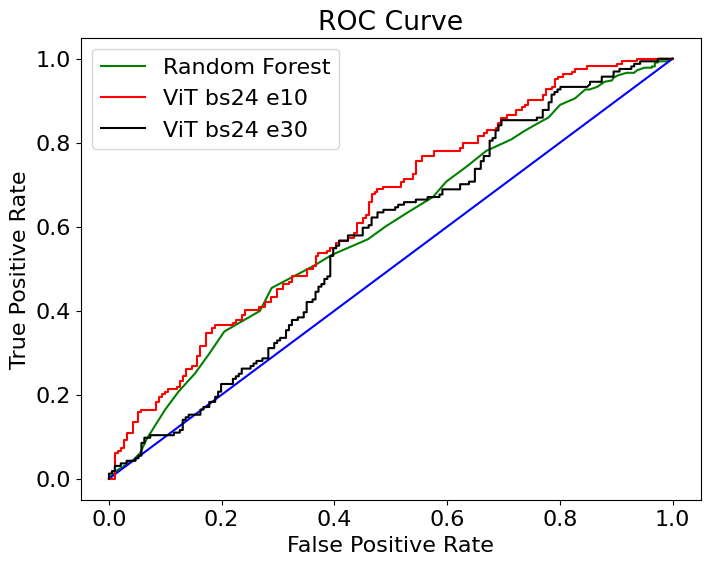

In [24]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd


df = pd.read_csv("../data/random_forest_predictions.csv")
rf_true,rf_pred, rf_prob = tuple([np.array(df[col]) for col in ['true', 'pred', 'prob']])

df = pd.read_csv("../data/vit-24-30/predictions.csv")
vit30_true, vit30_pred, vit30_prob = tuple([np.array(df[col]) for col in ['true', 'pred', 'prob']])

vit30_fpr, vit30_tpr, _ = roc_curve(vit30_true, -vit30_prob)
rf_fpr, rf_tpr, _ = roc_curve(rf_true, rf_prob)
diagonal_fpr, diagonal_tpr, _ = roc_curve(y_true, [1 for _ in range(len(y_true))])
model_fpr, model_tpr, _ = roc_curve(y_true, -y_prob)
plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
    
plt.plot(rf_fpr, rf_tpr, 'g', label = 'Random Forest')
plt.plot(diagonal_fpr, diagonal_tpr, 'b') # , label = 'model')
plt.plot(model_fpr, model_tpr, 'r', label = 'ViT bs24 e10')
plt.plot(vit30_fpr, vit30_tpr, 'black', label = 'ViT bs24 e30')
plt.legend();
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')


In [25]:
accuracy_score(vit30_true, vit30_pred)

0.7436619718309859

# Modell vom Checkpoint laden und an validation den accuracy score holen

In [14]:

checkpoint="../data/vit-8-20/model"
model = AutoModelForImageClassification.from_pretrained(checkpoint)
processor = AutoImageProcessor.from_pretrained(checkpoint)

v30_pred_train, v30_prob_train, v30_true_train = lib.get_pred_prob_true(ds_split['validation'], model, processor)

In [15]:
accuracy_score(v30_true_train, v30_pred_train)

0.8169014084507042